# 01. Exploring the impact of cyclones on vegetation: scene before and after cyclone

metadata blah

In [1]:
#Import libraries 

%pylab notebook
# from __future__ import print_function
import pandas as pd
import xarray as xr
from datetime import date, timedelta
import gdal
from gdal import *

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube_stats.statistics import GeoMedian

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio

dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specify directory locations

In [2]:
###User input: enter the directory location of input data. Ensure "/" are used, not "\"
input_folder = '/g/data/w85/ext547/input_data/'

###User input: enter the directory location of output data. Please enter again if the same as input_folder. Ensure "/" are used, not "\"
output_folder = '/g/data/w85/ext547/output_data/'

# User requirement: specifiy location of interest and details about cyclone

In [3]:
###User input: enter area of interest
lat_min = -20.385 #down
lat_max = -20.326 #up
lon_min = 148.916 #left
lon_max = 148.984 #right

##User input: enter the name of vegetation of interest, e.g. "forest" or "banana crop"
vegetation_type = 'forest'

###User input: enter start and end date of cyclone
start_of_event= '2017-03-23'
end_of_event= '2017-04-07'

###User input: enter the name of cyclone
cyclone_name =  'Debbie'

###User input: set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.80 

# No more "user requirements" just run the remaining cells

While the remaining cells do not require any changes, the user can edit code as required.

# Datacube query is completed

In [4]:
#Temporal range, wavelengths/band and sensors of interest are defined

#temporal range is defined
start_of_epoch = '2000-01-01'
end_of_epoch =  '2017-12-31'

#wavelengths/bands of interest are defined
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Landsat sensors of interest are defined
sensors = ['ls8', 
    'ls7',
    'ls5'] 

#query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2000-01-01', '2017-12-31'), 'x': (148.916, 148.984), 'y': (-20.326, -20.385), 'crs': 'EPSG:4326'}


In [5]:
#Reformat event date format 

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime

# Extract data from Open Datacube

The extracted data is first filtered using the criteria in "mask_components". 
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded.
Additionally, any pixel that is located within the ocean/sea will be converted to "nan" values with the 'land_sea' command.

In [6]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results. It should be noted the "land_sea" code will remove all ocean/sea pixels.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea': 'land'}

In [7]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #Discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [8]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 58, x: 315, y: 299)
 Coordinates:
   * time     (time) datetime64[ns] 2003-07-17T23:41:17.500000 ...
   * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
   * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
 Data variables:
     green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 147, x: 315, y: 299)
 Coordinates:
   * time     (time) datetime64[ns] 2000-01-06T23:57:40.500000 ...
   * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
   * x        (x) float64 1.7

In [9]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [10]:
#Check that the concatenation worked

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 253, x: 315, y: 299)
Coordinates:
  * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
  * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
  * time     (time) datetime64[ns] 2000-01-06T23:57:40.500000 ...
Data variables:
    green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    product  (time) <U3 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1751300.00|\n| 0.00,-25.00,-2296525.00|\n| 0.00,...

# Find the scenes that occur before and after cyclone

In [11]:
#Retun time and sensor information
product_time = nbar_clean[['time', 'product']].to_dataframe() #Add time and product to dataframe
product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

In [12]:
#Save cyclone "event" date in correct format for plotting
event_dates=pd.DataFrame()
delta = end_of_event - start_of_event
for i in range(delta.days + 1):
    date=start_of_event + timedelta(days=i)
    date=pd.DataFrame([date],index=None)
    event_dates=event_dates.append(date)
event_dates.columns=['date']
event_dates=event_dates.set_index('date',drop=False)
event_dates.index=event_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
event_dates['value']=1

In [13]:
#Save "interest dates" in correct format for plotting. Interest dates are set to help visulise avaliable scenes on either side of the cyclone.
start_of_interest= start_of_event+datetime.timedelta(days=-200) #default of 200 days
end_of_interest= end_of_event+datetime.timedelta(days=200) #default of 200 days

interest_dates=pd.DataFrame()
delta = end_of_interest - start_of_interest
for i in range(delta.days + 1):
    date=start_of_interest + timedelta(days=i)
    date=pd.DataFrame([date],index=None)
    interest_dates=interest_dates.append(date)

interest_dates.columns=['date']
interest_dates=interest_dates.set_index('date',drop=False)
interest_dates.index=interest_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
interest_dates['value']=1

In [14]:
#Merge dates of interest with the Landsat scenes to match dates
subset_data = pd.merge(interest_dates, product_time, left_index=True,#left_on= 'date', 
                       right_index=True, how='inner') #Match dates and merge

# Create an interactive graph that shows suitable imagery before and after the cyclone

<IPython.core.display.Javascript object>


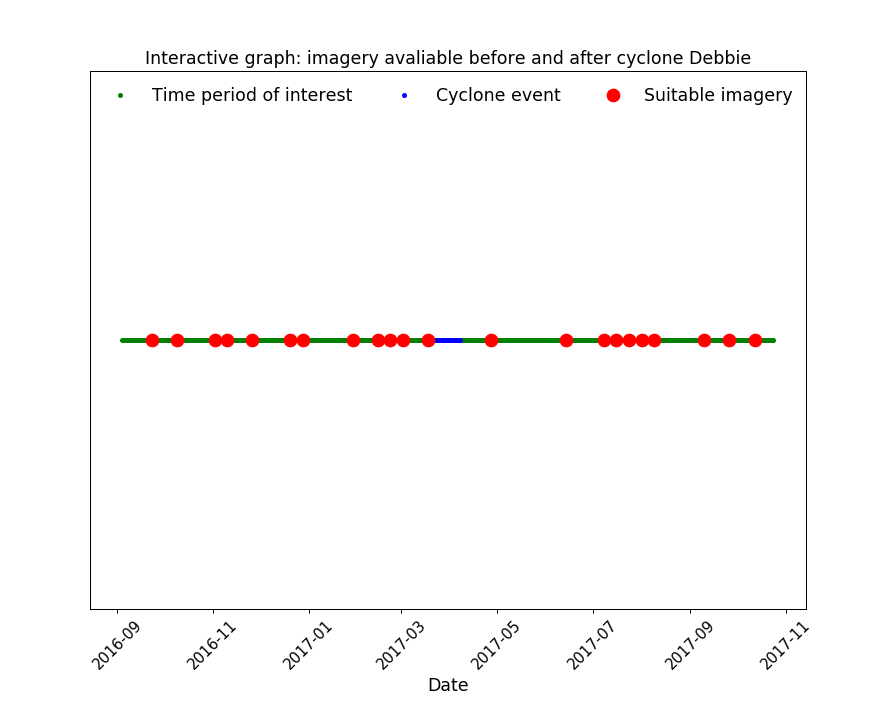

HTML(value='Event information appears here when you click on the figure')

In [38]:
#Create interactive plot that enables the user to select a scene. User should select a scene before the cyclone event

#create widget that enables interaction with plot
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global date_int, devent
    devent = event
    date_int = event.xdata
    time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#Set up plot
fig = plt.figure(figsize=(10,8)) #Set plot size
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive graph: imagery avaliable before and after cyclone ' +str(cyclone_name), size=14) #Plot title
display(w) #Plot setup with interactive widget
plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.15) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white

#Plot dates of interest, dates of cyclone and dates of imagery
plt.plot_date(interest_dates.date,interest_dates.value, 'g.', 
                            label= 'Time period of interest')
plt.plot_date(event_dates.date,event_dates.value, 'b.', 
                            label= 'Cyclone event')
plt.plot_date(subset_data.date,subset_data.value, 'r.', markersize=20,
                            label= 'Suitable imagery') #the term "suitable" is defined by cloud_free_threshold.
#Axis details
plt.yticks([]) #remove y axis values as not required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot

plt.show() #Plot setup

In [19]:
#Save figure
plt.savefig(str(output_folder)+'imagery_avaliable_cyclone_'+str(cyclone_name))

In [20]:
#reformat and show date clicked on interactive graph
time_slice = matplotlib.dates.num2date(date_int).date()
time_slice=format(time_slice,'%Y-%m-%d %H:%M:%S')
time_slice= str(time_slice) #Convert to string
time_slice=datetime.datetime.strptime(time_slice,'%Y-%m-%d  %H:%M:%S') #Convert to datetime
time_slice

datetime.datetime(2017, 3, 17, 0, 0)

In [21]:
#Prepare imagery
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


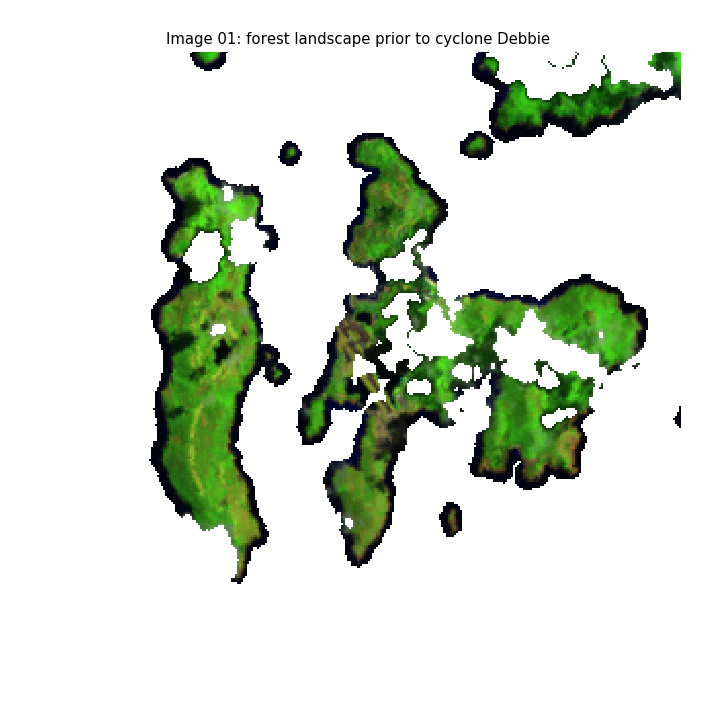

In [61]:
#Create image that shows landscape before cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white 
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis 
plt.title('Image 01: ' + str(vegetation_type)+ ' landscape prior to cyclone '+ str(cyclone_name)) #add title
plt.imshow(scaled, interpolation = 'nearest') #create image
plt.show() #show image

In [26]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi_of_interest= ndvi.sel(time = time_slice, method='nearest') #select scene

ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

<IPython.core.display.Javascript object>


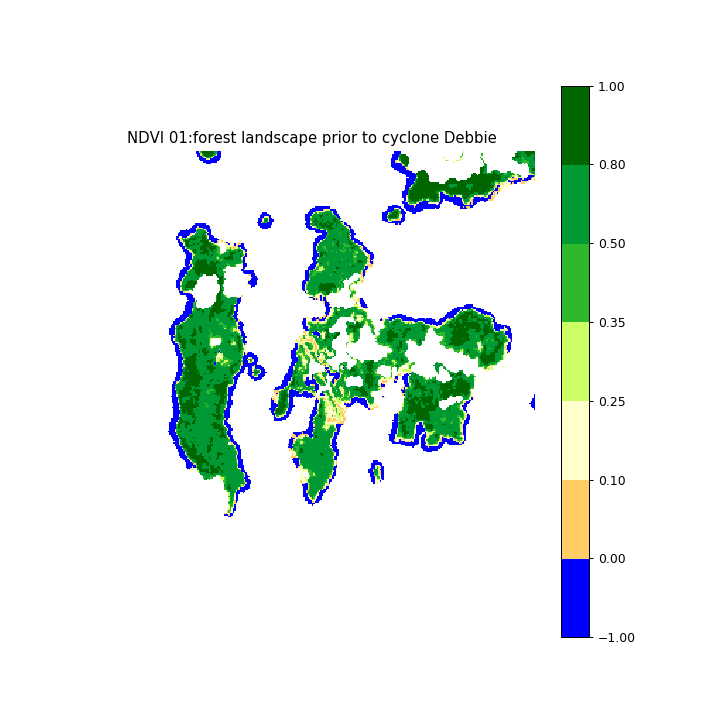

In [60]:
#Plot NDVI for scene prior to cyclone

#Controls for NDVI colour map
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

#Create plot
fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.axis('off')#remove axis 
plt.title('NDVI 01: ' + str(vegetation_type)+ ' landscape prior to cyclone '+ str(cyclone_name)) #add title
i=plt.imshow(ndvi_of_interest,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colour bar

# Landscape and NDVI of scene after cyclone

<IPython.core.display.Javascript object>


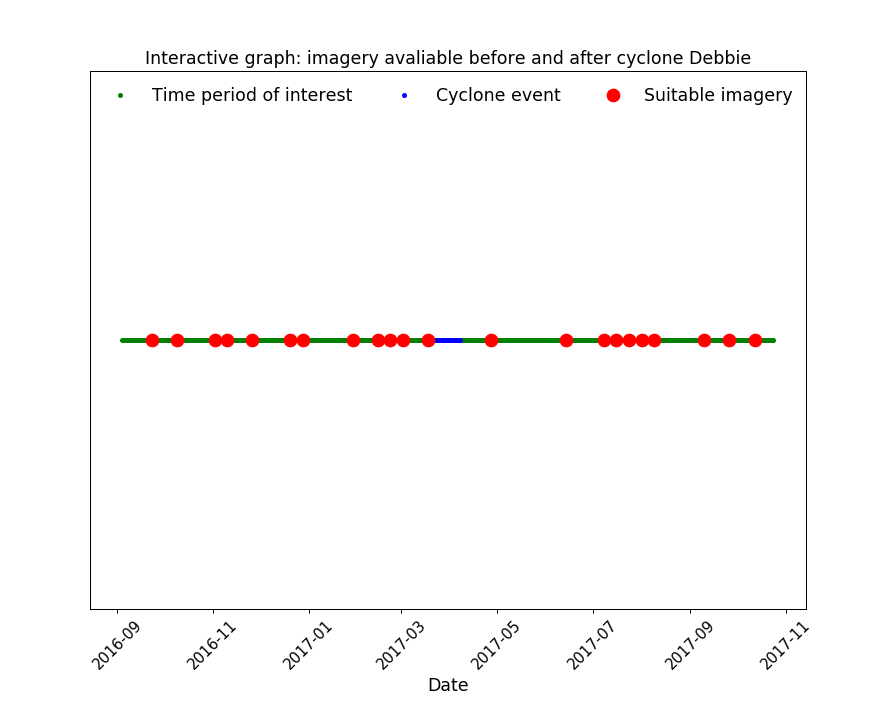

HTML(value='Event information appears here when you click on the figure')

In [33]:
#Create interactive plot that enables the user to select a scene. User should select a scene after the cyclone event

#create widget that enables interaction with plot
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global date_int2, devent
    devent = event
    date_int2 = event.xdata
    time_int_ = time_int2.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#Set up plot
fig = plt.figure(figsize=(10,8)) #Set plot size
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive graph: imagery avaliable before and after cyclone ' +str(cyclone_name), size=14) #Plot title
display(w) #Plot setup with interactive widget
plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.15) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white

#Plot dates of interest, dates of cyclone and dates of imagery
plt.plot_date(interest_dates.date,interest_dates.value, 'g.', 
                            label= 'Time period of interest')
plt.plot_date(event_dates.date,event_dates.value, 'b.', 
                            label= 'Cyclone event')
plt.plot_date(subset_data.date,subset_data.value, 'r.', markersize=20,
                            label= 'Suitable imagery') #the term "suitable" is defined by cloud_free_threshold.
#Axis details
plt.yticks([]) #remove y axis values as not required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot

plt.show() #Plot setup

In [42]:
time_slice02 = matplotlib.dates.num2date(date_int2).date()
time_slice02=format(time_slice02,'%Y-%m-%d %H:%M:%S')
time_slice02= str(time_slice02) #Convert to string
time_slice02=datetime.datetime.strptime(time_slice02,'%Y-%m-%d  %H:%M:%S') #Convert to datetime
time_slice02

datetime.datetime(2017, 4, 26, 0, 0)

In [43]:
#Prepare imagery for scene after cyclone

rgb02 = nbar_clean.sel(time =time_slice02, method = 'nearest').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb02 = rgb02.astype('double')
clipped_visible02 = rgb02.where(rgb02<fake_saturation).fillna(fake_saturation)
max_val02 = clipped_visible02.max(['y', 'x'])
scaled02 = (clipped_visible02 / max_val02)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


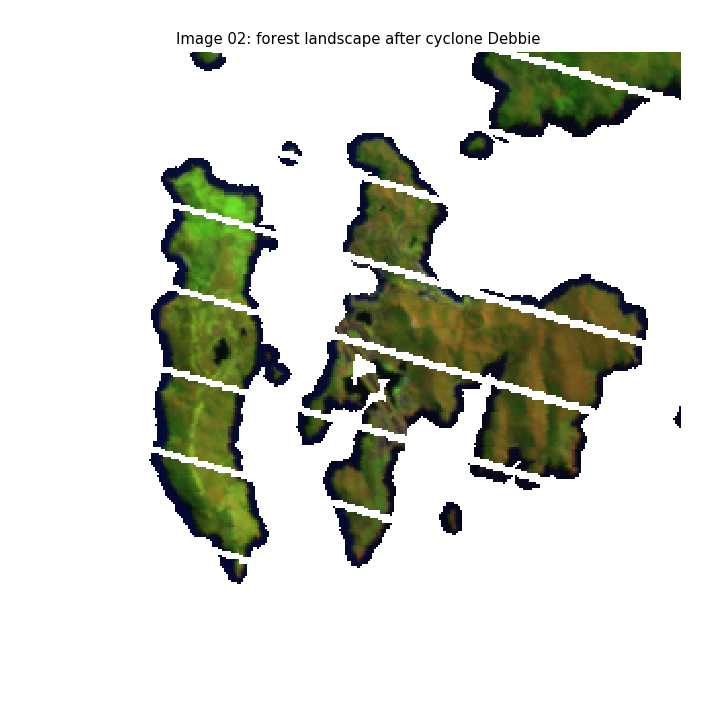

In [62]:
#Create image that shows landscape after cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis
plt.title('Image 02: ' + str(vegetation_type)+ ' landscape after cyclone '+ str(cyclone_name)) #add title
plt.imshow(scaled02, interpolation = 'nearest') #create image
plt.show() #show image

In [47]:
#Select NDVI for scene after cyclone
ndvi_of_interest02= ndvi.sel(time = time_slice02, method='nearest')
ndvi_of_interest02

<xarray.DataArray (y: 299, x: 315)>
array([[      nan,       nan,       nan, ...,  0.608438,  0.604264,  0.557012],
       [      nan,       nan,       nan, ...,  0.58947 ,  0.597904,  0.6     ],
       [      nan,       nan,       nan, ...,  0.59342 ,  0.576737,  0.584855],
       ..., 
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
  * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
    time     datetime64[ns] 2017-04-27T00:07:15.500000
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1751300.00|\n| 0.00,-25.00,-2296525.00|\n| 0.00,...

<IPython.core.display.Javascript object>


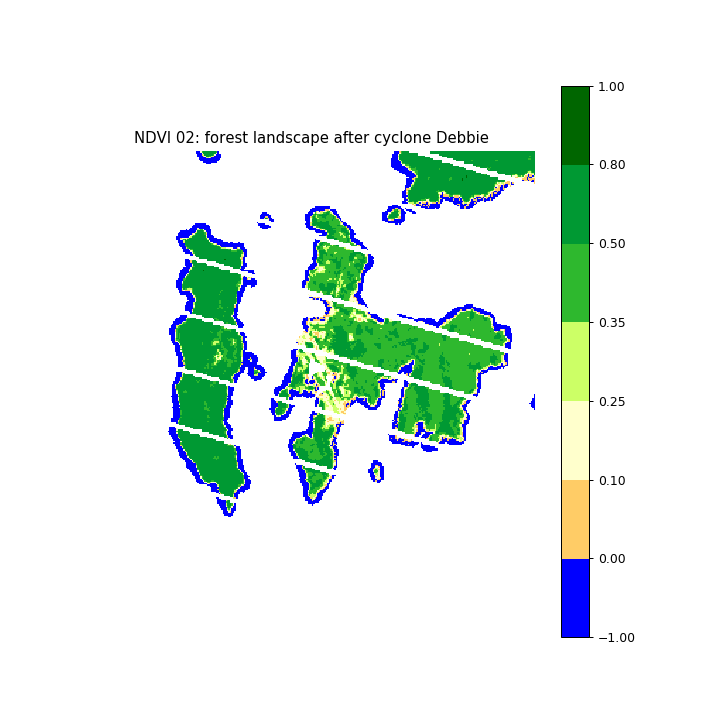

In [63]:
#Plot NDVI for scene after cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.axis('off')#remove axis 
plt.title('NDVI 02: ' + str(vegetation_type)+ ' landscape after cyclone '+ str(cyclone_name)) #add title
i=plt.imshow(ndvi_of_interest02,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colour bar

# Change in vegetation before/after cyclone

In [54]:
#Calculate the difference in NDVI from before to after cyclone

ndvi_change= ndvi_of_interest02-ndvi_of_interest
ndvi_change.attrs['affine'] = affine

<IPython.core.display.Javascript object>


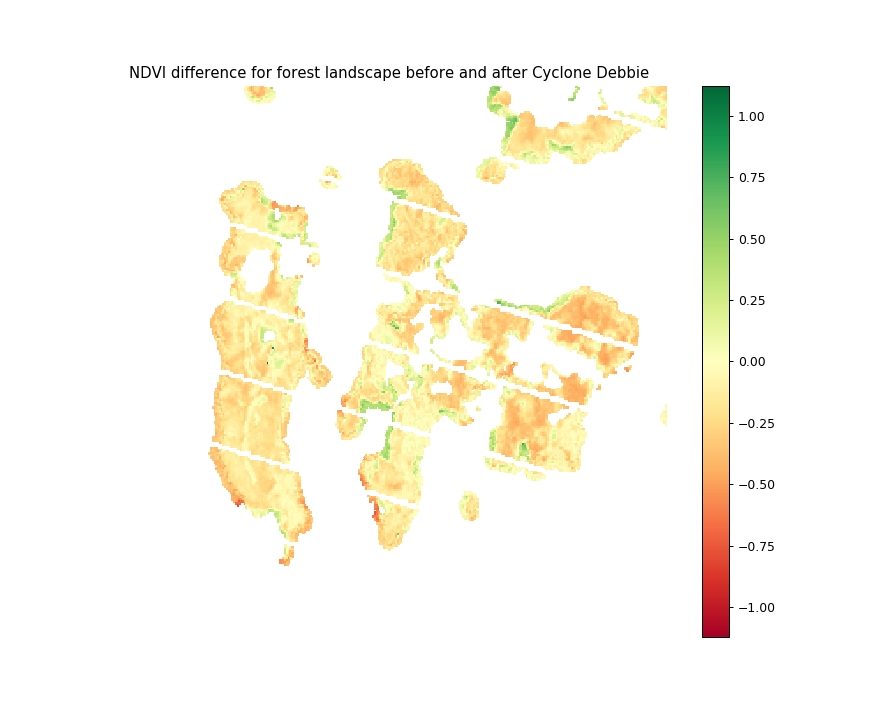

In [67]:
#Plot the change of NDVI
fig = plt.figure(figsize=(10,8)) #create plot
ndvi_change.plot(cmap = 'RdYlGn') #create image
plt.title('NDVI difference for '+str(vegetation_type)+ ' landscape before and after Cyclone '+str(cyclone_name)) #add title
plt.axis('off')#remove axis
plt.show() #show image

# Import and process windfield data to ensure pixel size and projection is the same as NDVI dataset

In [ ]:
#read windfield geotiff
windfield = gdal.Open(input_folder+'Final_corrected_TCDebbie_wind.tif', gdal.GA_ReadOnly)
windfield

In [ ]:
#get projection information from windfiled
windfield_proj = windfield.GetProjection()
windfield_proj

In [ ]:
#Convert NDVI data array to raster saved in memory

#save NDVI_change dataset to a numpy array
ndvi_array = np.asarray(ndvi_change)

#define conversion variables
cols= int(ndvi_change.x.count())
rows= int(ndvi_change.y.count())
originX= ndvi_change.affine.c
dx= ndvi_change.affine.a
originY= ndvi_change.affine.f
dy= ndvi_change.affine.e
epsg=int((str(crs)).replace('EPSG:',''))
nodata=0

#complete conversion of NDVI array into raster
driver = gdal.GetDriverByName('MEM')
ndvi_raster = driver.Create('ndvi', cols, rows, 1, gdal.GDT_Float32)
ndvi_raster.SetGeoTransform((originX, dx, 0, originY, 0, dy))
ndvi_band = ndvi_raster.GetRasterBand(1)
ndvi_band.WriteArray(ndvi_array)
ndvi_band.SetNoDataValue(nodata)
ndvi_raster_SRS = osr.SpatialReference()
ndvi_raster_SRS.ImportFromEPSG(epsg)
ndvi_raster.SetProjection(ndvi_raster_SRS.ExportToWkt())
ndvi_band.FlushCache()

In [ ]:
#Save metadata from NDVI_change
match_ds = ndvi_raster
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

In [ ]:
#Create a  geotiff that is the same size and is in the same projection as the NDVI dataset
drv = gdal.GetDriverByName('GTiff')
windfield_matched = drv.Create('ouput_file', wide, high, 1, gdal.GDT_Float32)
windfield_matched.SetGeoTransform(match_geotrans)
windfield_matched.SetProjection(match_proj)

#create windfield geotiff
resampling_method = gdalconst.GRA_Bilinear
gdal.ReprojectImage(windfield, windfield_matched, windfield_proj, match_proj, resampling_method)

#view datasets and projections to ensure information looks correct
print ('windfield       = ', windfield)
print ('windfield_matched             = ',windfield_matched)
print ('windfield_proj        = ',windfield_proj)
print ('match_proj      = ',match_proj)

# Save resampled windfield as an array and check array shape

In [ ]:
windfield_matched_array=windfield_matched.ReadAsArray()

print('windfield shape = '+ str(shape(windfield_matched_array)))
print('ndvi_change shape = '+ str(shape(ndvi_change.values)))

# Create a plot that examines relationship between wind and change in NDVI after a cyclone

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(windfield_matched_array, ndvi_change.values, 'ro') 
plt.axis([50 , 120 ,-1.0, 1.0], 'tight')
plt.xlabel('Modelled wind field (km h$^{-1}$)') #Set X label
plt.ylabel('Change in NDVI before and after Cyclone '+str(cyclone_name)) #Set Y label

plt.show()